<a href="https://colab.research.google.com/github/chloedoobs/HRV_Project/blob/main/HRV_Resonant_Freq_Calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shared notebook for analysing the signals from the BITalino, to ensure that via our method we have correctly identified and ascertained each individuals resonant frequency (Baroreflex).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks, butter, filtfilt, welch
from scipy.ndimage import gaussian_filter1d

In [ ]:
# CONFIGURATION

data_files = {
    'baseline': 'luzie_baseline_2025-12-13_11-56-52.txt',
    '6.0_bpm': 'Luzie_6pm_2025-12-13_12-02-48.txt',
    '5.5_bpm': 'Luzie_5.5bpm_2025-12-13_12-09-45.txt',
    '5.0_bpm': 'luzie_5bpm_2025-12-13_12-15-11.txt',
    '4.5_bpm': 'luzie_4.5bpm_2025-12-13_12-21-27.txt'
}

sampling_rate = 1000
ecg_column = 'A2'
analyze_start_sec = 20
analyze_duration_sec = 180

In [ ]:
# HELPER FUNCTIONS

def load_bitalino(file_path):
    df = pd.read_csv(file_path, sep=r"\s+", skiprows=3, header=None, engine="python")
    if len(df.columns) >= 11: #luzie's data
        df.columns = ['nSeq','I1','I2','O1','O2','A1','A2','A3','A4','A5','A6']
    elif len(df.columns) >= 5: #camilles data
        df.columns = ['nSeq','I1','I2','O1','O2','A2']
    else:
      print('error - wrong number of columns')

    return df

def detect_r_peaks(ecg, fs):
    nyq = fs/2
    b,a = butter(2, [1/nyq, 50/nyq], btype="band")
    ecg_filt = filtfilt(b, a, ecg)
    threshold = np.mean(ecg_filt) + 0.5*np.std(ecg_filt)
    peaks,_ = find_peaks(ecg_filt, distance=int(0.4*fs), height=threshold, prominence=np.std(ecg_filt)*0.2)
    return peaks

def remove_outliers(rr, low=300, high=2000):
    return rr[(rr>=low) & (rr<=high)]

def time_domain_metrics(rr_ms):
    rr_clean = remove_outliers(rr_ms)
    if len(rr_clean) < 10:
        return None
    mean_rr = np.mean(rr_clean)
    sdnn = np.std(rr_clean, ddof=1)
    rmssd = np.sqrt(np.mean(np.diff(rr_clean)**2))
    mean_hr = 60000/mean_rr
    return {"mean_rr": mean_rr, "mean_hr": mean_hr, "sdnn": sdnn, "rmssd": rmssd}

def frequency_domain_metrics(rr_ms, fs_resample=4):
    rr_clean = remove_outliers(rr_ms)
    if len(rr_clean) < 20:  # Not enough intervals
        return None

    rr_times = np.cumsum(rr_clean)/1000.0
    rr_times -= rr_times[0]

    if len(rr_times) < 2:  # Too short to interpolate
        return None

    # Create regular grid
    time_grid = np.arange(0, rr_times[-1], 1/fs_resample)
    if len(time_grid) < 2:  # Avoid empty grid
        time_grid = np.array([0, rr_times[-1]])

    # Safe interpolation
    rr_interp = np.interp(time_grid, rr_times[:-1], rr_clean[:-1])
    rr_interp -= np.mean(rr_interp)

    freqs, psd = welch(rr_interp, fs=fs_resample, nperseg=min(256, len(rr_interp)))

    vlf = (0.0033, 0.04)
    lf = (0.04, 0.15)
    hf = (0.15, 0.4)
    vlf_power = np.trapz(psd[(freqs>=vlf[0]) & (freqs<vlf[1])], freqs[(freqs>=vlf[0]) & (freqs<vlf[1])])
    lf_power = np.trapz(psd[(freqs>=lf[0]) & (freqs<lf[1])], freqs[(freqs>=lf[0]) & (freqs<lf[1])])
    hf_power = np.trapz(psd[(freqs>=hf[0]) & (freqs<hf[1])], freqs[(freqs>=hf[0]) & (freqs<hf[1])])

    return {"vlf_power": vlf_power, "lf_power": lf_power, "hf_power": hf_power,
            "total_power": vlf_power+lf_power+hf_power,
            "lf_hf_ratio": lf_power/hf_power if hf_power>0 else 0}

def peak_trough_hr(rr_ms):
    rr_clean = remove_outliers(rr_ms)
    hr = 60000/rr_clean
    hr_smooth = gaussian_filter1d(hr, sigma=2)
    peaks,_ = find_peaks(hr_smooth, distance=5)
    troughs,_ = find_peaks(-hr_smooth, distance=5)
    if len(peaks)>1 and len(troughs)>1:
        return np.mean(hr_smooth[peaks]) - np.mean(hr_smooth[troughs])
    return np.max(hr)-np.min(hr)


In [ ]:
def compute_psd(rr_ms, fs_resample=4):
    rr_clean = remove_outliers(rr_ms)
    if len(rr_clean) < 10:
        return None, None

    rr_times = np.cumsum(rr_clean)/1000.0
    rr_times -= rr_times[0]

    if len(rr_times) < 2:
        return None, None

    time_grid = np.arange(0, rr_times[-1], 1/fs_resample)
    if len(time_grid) < 2:
        time_grid = np.array([0, rr_times[-1]])

    rr_interp = np.interp(time_grid, rr_times[:-1], rr_clean[:-1])
    rr_interp -= np.mean(rr_interp)

    freqs, psd = welch(rr_interp, fs=fs_resample, nperseg=min(256, len(rr_interp)))
    return freqs, psd


In [ ]:
# MAIN ANALYSIS

results = {}
for label, file in data_files.items():
    df = load_bitalino(file)
    ecg = df[ecg_column].values
    start = int(analyze_start_sec*sampling_rate)
    end = int((analyze_start_sec+analyze_duration_sec)*sampling_rate)
    ecg_segment = ecg[start:end]
    r_peaks = detect_r_peaks(ecg_segment, sampling_rate)

    if len(r_peaks)<20:
        print(f"Skipping {label}: too few peaks")
        continue
    rr_ms = np.diff(r_peaks)/sampling_rate*1000
    td = time_domain_metrics(rr_ms)
    fd = frequency_domain_metrics(rr_ms)
    pt = peak_trough_hr(rr_ms)

    if td is None or fd is None:
        print(f"Skipping {label}: insufficient RR intervals")
        continue

    # Store all metrics
    results[label] = {
        "mean_hr": td["mean_hr"],
        "rmssd": td["rmssd"],
        "sdnn": td["sdnn"],
        "lf_power": fd["lf_power"],
        "hf_power": fd["hf_power"],
        "total_power": fd["total_power"],
        "lf_hf_ratio": fd["lf_hf_ratio"],
        "peak_trough_hr": pt
    }

/tmp/ipython-input-787977596.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  vlf_power = np.trapz(psd[(freqs>=vlf[0]) & (freqs<vlf[1])], freqs[(freqs>=vlf[0]) & (freqs<vlf[1])])
/tmp/ipython-input-787977596.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[(freqs>=lf[0]) & (freqs<lf[1])], freqs[(freqs>=lf[0]) & (freqs<lf[1])])
/tmp/ipython-input-787977596.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[(freqs>=hf[0]) & (freqs<hf[1])], freqs[(freqs>=hf[0]) & (freqs<hf[1])])
/tmp/ipython-input-787977596.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  vlf_power =

In [ ]:
# Print the Summary

print(f"\n{label} summary:")
print(f"  Mean HR: {td['mean_hr']:.1f} bpm")
print(f"  SDNN: {td['sdnn']:.1f} ms")
print(f"  RMSSD: {td['rmssd']:.1f} ms")
print(f"  LF Power: {fd['lf_power']:.1f} ms²")
print(f"  HF Power: {fd['hf_power']:.1f} ms²")
print(f"  Peak-Trough HR: {pt:.1f} bpm")



4.5_bpm summary:
  Mean HR: 64.9 bpm
  SDNN: 246.1 ms
  RMSSD: 235.2 ms
  LF Power: 36381.2 ms²
  HF Power: 9685.6 ms²
  Peak-Trough HR: 18.7 bpm


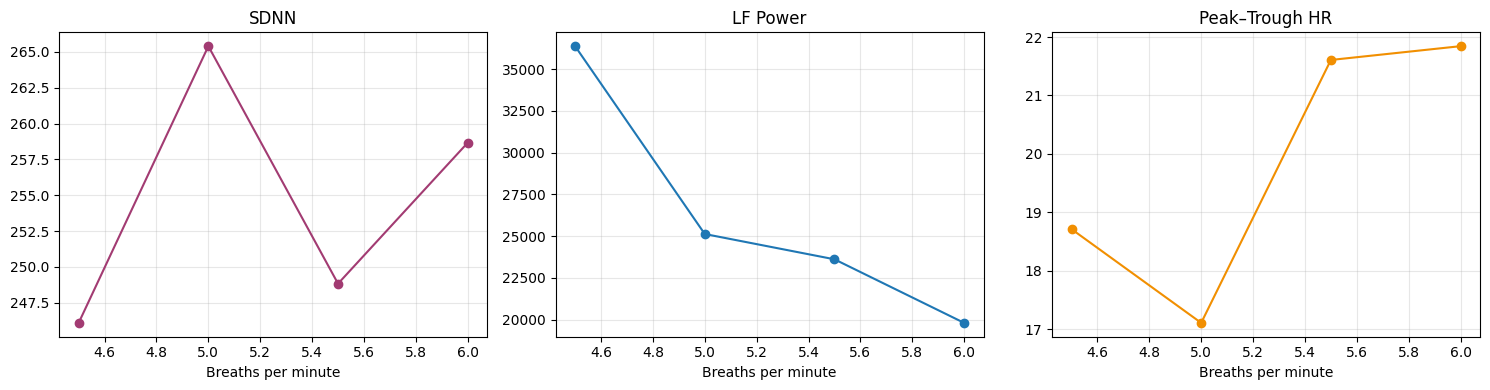

In [ ]:
# PLOTTING

freq_order = sorted([k for k in results if k!="baseline"], key=lambda x: float(x.replace("_bpm","")))
freq_values = [float(k.replace("_bpm","")) for k in freq_order]
sdnn_vals = [results[k]["sdnn"] for k in freq_order]
lf_vals = [results[k]["lf_power"] for k in freq_order]
pt_vals = [results[k]["peak_trough_hr"] for k in freq_order]

fig, axs = plt.subplots(1,3,figsize=(15,4))
ax0 = axs[0].plot(freq_values, sdnn_vals,"o-", color='#A23B72'); axs[0].set_title("SDNN")
# ax0.set_ylabel('SDNN (ms)')
ax1 = axs[1].plot(freq_values, lf_vals,"o-"); axs[1].set_title("LF Power")
# ax1.set_ylabel('LF Power (ms²)')
ax2 = axs[2].plot(freq_values, pt_vals,"o-", color='#F18F01'); axs[2].set_title("Peak–Trough HR")
# ax2.set_ylabel('Peak-Trough HR (bpm)')
for ax in axs:
    ax.set_xlabel("Breaths per minute")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


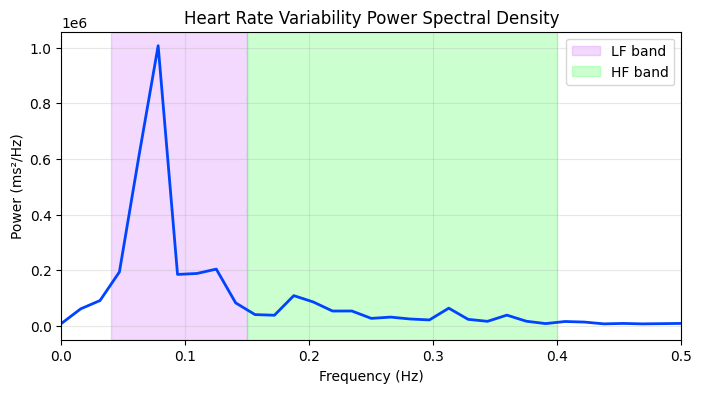

In [ ]:
#Spectral Analysis Plot

freqs, psd = compute_psd(rr_ms)

plt.figure(figsize=(8,4))
plt.plot(freqs, psd, color="#0044ff", linewidth=2)
plt.axvspan(0.04, 0.15, color="#c242f5", alpha=0.2, label="LF band")
plt.axvspan(0.15, 0.4, color="#00ff15", alpha=0.2, label="HF band")
plt.title("Heart Rate Variability Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (ms²/Hz)")
plt.xlim(0, 0.5)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# IDENTIFY RESONANCE

resonance_lf = max(results, key=lambda k: results[k]["lf_power"])
print(f"Recommended resonance frequency based on LF Power: {resonance_lf}")

resonance_hr = max(results, key=lambda k: results[k]["peak_trough_hr"])
print(f"Recommended resonance frequency based on Peak Trough Amplitude: {resonance_hr}")

Recommended resonance frequency based on LF Power: 4.5_bpm
Recommended resonance frequency based on Peak Trough Amplitude: 6.0_bpm


In [ ]:
# SAVING

# Convert results dict to DataFrame and save - this is set up to save luzies
pd.DataFrame(results).T.to_csv("hrv_metrics_luzie.csv", index=True)

In [ ]:
# Checking Saved Data

df_luzie = pd.read_csv("hrv_metrics_luzie.csv", index_col=0)
print(df_luzie)
print('----------- \n')
df_camille = pd.read_csv("hrv_metrics_camille.csv", index_col=0)
print(df_camille)

            mean_hr       rmssd        sdnn      lf_power      hf_power  \
baseline  80.323525  330.670724  272.459522  14387.174886   9607.891412   
6.0_bpm   74.022799  303.096204  258.659714  19798.207108  17632.120829   
5.5_bpm   70.785035  262.871565  248.826183  23609.101442  13009.058101   
5.0_bpm   73.471077  316.427456  265.397767  25124.124816  17619.536041   
4.5_bpm   64.881390  235.183557  246.089077  36381.205667   9685.604776   

           total_power  lf_hf_ratio  peak_trough_hr  
baseline  23995.066298     1.497433       18.276414  
6.0_bpm   39016.343852     1.122849       21.843350  
5.5_bpm   38311.094917     1.814820       21.607344  
5.0_bpm   47351.383130     1.425924       17.109682  
4.5_bpm   47248.412204     3.756214       18.713628  
----------- 

            mean_hr       rmssd        sdnn      lf_power     hf_power  \
baseline  80.547112   71.582154   72.346000   1461.503450   530.830830   
6.0_bpm   92.813290  112.691088  141.445935  15183.817164  2642